In [ ]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# import plots_preward as plots_preward

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from tkinter import font
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import math 

from numpy.typing import ArrayLike
from typing import Literal, Tuple

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from IPython.display import display
from matplotlib.patches import Rectangle

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'


# Batch 3 - Preward depletion with three odors. 

# Compute for more sessions

In [ ]:
summary_df = pd.DataFrame()
#Don't change this date
date = datetime.datetime.strptime("4/25/2024", "%m/%d/%Y").date()
# date = datetime.datetime.strptime("5/12/2024", "%m/%d/%Y").date()

In [76]:
summary_df = pd.DataFrame()
all_epochs = pd.DataFrame()

for mouse in ["715866", "713578", "707349", "716455", "716458","715865","715869","713545","715867","715870","694569"]:
    session_n = 0
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)
    for file_name in sorted_files:
        print(file_name)
        session_path = os.path.join(base_path, mouse, file_name)
        session = file_name[:8]
        session_path = Path(session_path)
        
        if datetime.date.fromtimestamp(os.path.getctime(session_path)) < date:
            continue
        else:
            print('correct date found')
        
        data = parse.load_session_data(session_path)
        
        if 'TaskLogic' in data['config'].streams.keys():
            tasklogic = 'TaskLogic'
        else:
            tasklogic = 'tasklogic_input'
            
        data['config'].streams[tasklogic].load_from_file()
        
        if 'environment_statistics' in data['config'].streams[tasklogic].data:
            environment = 'environment_statistics'
            reward_specification = 'reward_specification'
            odor_index = 'reward_function'
        else:
            environment = 'environmentStatistics'
            reward_specification = 'rewardSpecifications'
            odor_index = 'odorIndex'

        # Don't select the session if the preward is constant (that means this is not the type of experiment we want for this analysis)
        if (data['config'].streams[tasklogic].data[environment]['patches'][0][reward_specification]['reward_function']['probability']['function_type'] == 'ConstantFunction' and 
            data['config'].streams[tasklogic].data[environment]['patches'][1][reward_specification]['reward_function']['probability']['function_type'] == 'ConstantFunction'):
            print('Not good session')
            continue
        
        if (data['config'].streams[tasklogic].data[environment]['patches'][0][reward_specification]['reward_function']['probability']['a'] == 0.6 and 
            data['config'].streams[tasklogic].data[environment]['patches'][1][reward_specification]['reward_function']['probability']['a'] == 0.9):
            experiment = 'base'

        else:
            experiment = 'experiment1'
        
        print(f'Good session and {experiment}')

        session_n+=1
        
        # Parse data
        reward_sites, active_site, config = parse.parse_dataframe(data)
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        
        reward_sites['perceived_reward_probability'] = reward_sites['after_choice_cumulative_rewards'] / (reward_sites['visit_number'] +1)
        
        # plots_preward.p_reward_real_perceived(reward_sites, mouse, session, pdf)
        # plots_preward.p_reward_real_perceived_relationship(reward_sites, pdf)
        # plots_preward.total_rewards_failures_preward(reward_sites, pdf)
        
        if experiment =='experiment1' and reward_sites.reward_probability.max() == 0.6:
            environment = 'low'
        elif experiment =='experiment1' and reward_sites.reward_probability.max() == 0.9:
            environment = 'high'
        else:
            environment = 'mix'
            
        reward_sites['mouse'] = mouse
        reward_sites['session'] = session
        reward_sites['session_number'] = session_n
        reward_sites['experiment'] = experiment
        reward_sites['environment'] = environment

        summary_df = pd.concat([summary_df, reward_sites])
        all_epochs =  pd.concat([all_epochs, active_site])

20240409T100955
20240410T095511
20240411T101934
20240412T101435
20240413T105915
20240415T101229
20240416T103718
20240416T105252
20240417T110854
20240418T103432
20240419T104220
20240422T104054
20240422T110031
20240423T100551
20240424T102938
20240425T102305
correct date found
Good session and base
20240426T101144
correct date found
Good session and base
20240429T103414
correct date found
Good session and base
20240430T102108
correct date found
Good session and base
20240501T095811
correct date found
Good session and base
20240502T094324
correct date found
Good session and base
20240503T094055
correct date found
Good session and base
20240506T100408
correct date found
Good session and base
20240507T105659
correct date found
Good session and base
20240508T104947
correct date found
Good session and base
20240509T094946
correct date found
Good session and base
20240510T100828
correct date found
Good session and base
20240513T104111
correct date found
Good session and base
20240514T103233
cor

In [77]:
if summary_df.empty:
    print('Loading')
    summary_df = pd.read_csv(os.path.join(data_path, 'reward_probability_joined.csv'))
else:
    print('Saving')
    summary_df.to_csv(os.path.join(data_path, 'reward_probability_joined.csv'))

Saving


In [78]:
summary_df = summary_df.loc[~((summary_df.skipped_count > 3) & (summary_df.active_patch > 50))]

In [79]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

In [80]:
experiment_df = summary_df[summary_df['experiment'] == 'experiment1']
base_df = summary_df[summary_df['experiment'] == 'base']

### Mouse per mouse estimate of the p(reward) decaying fit

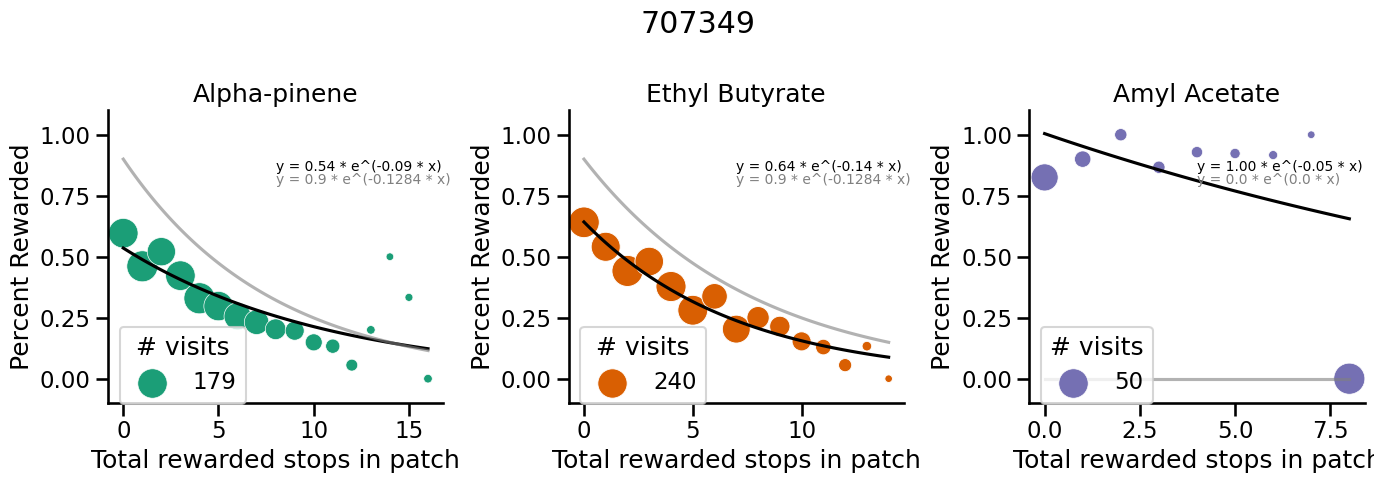

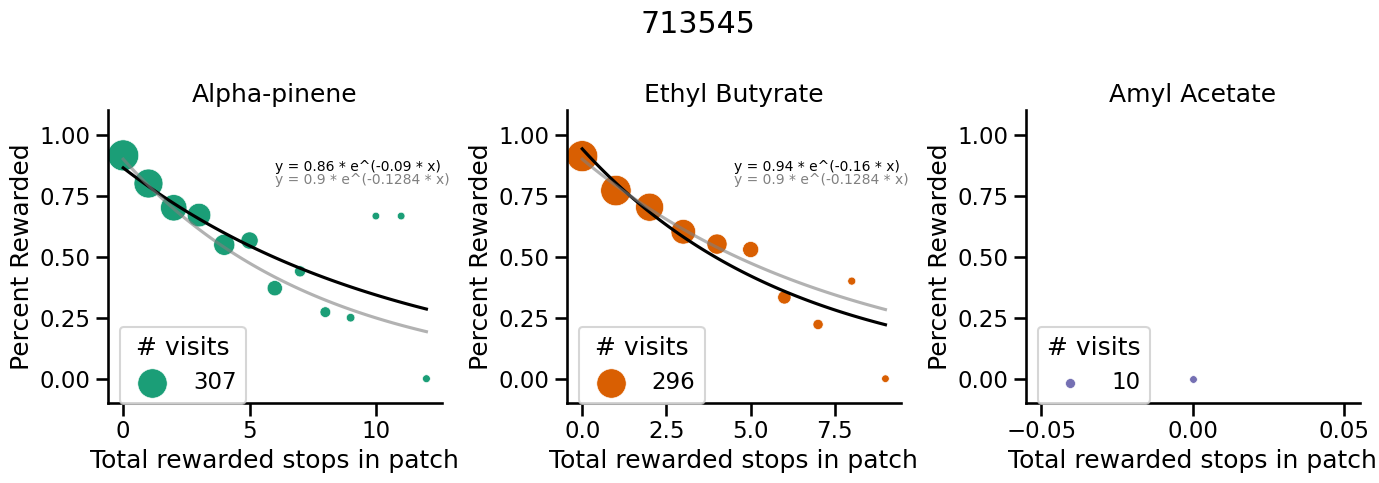

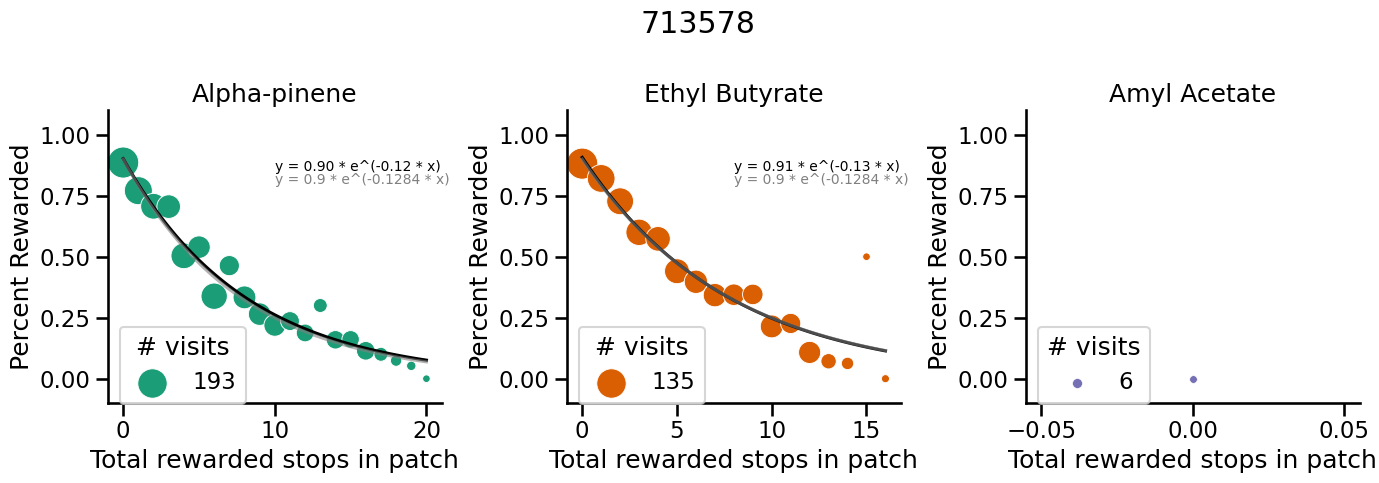

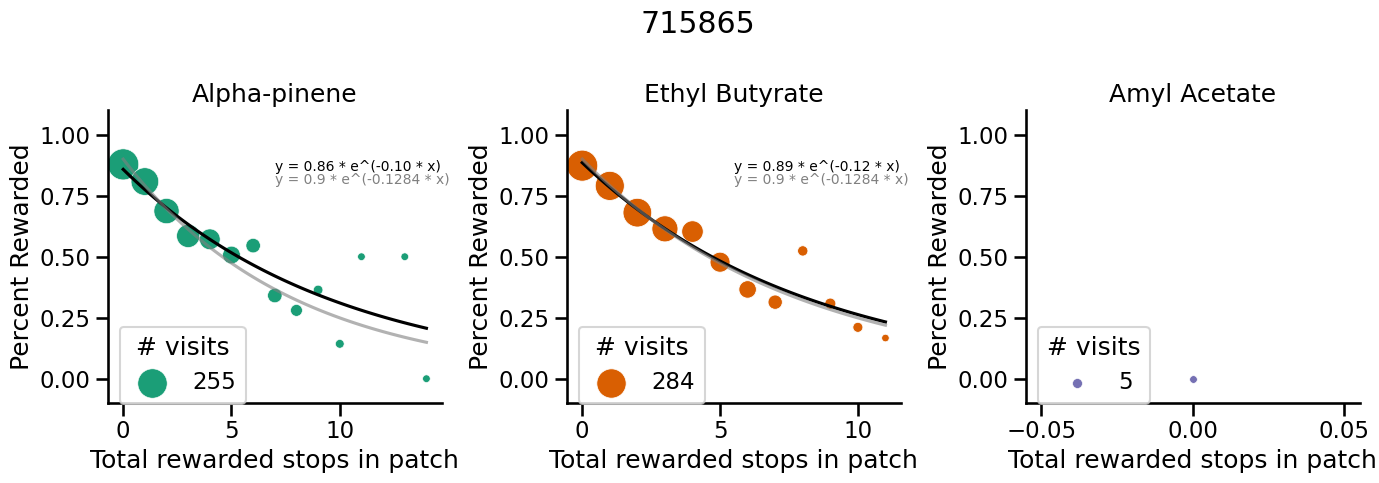

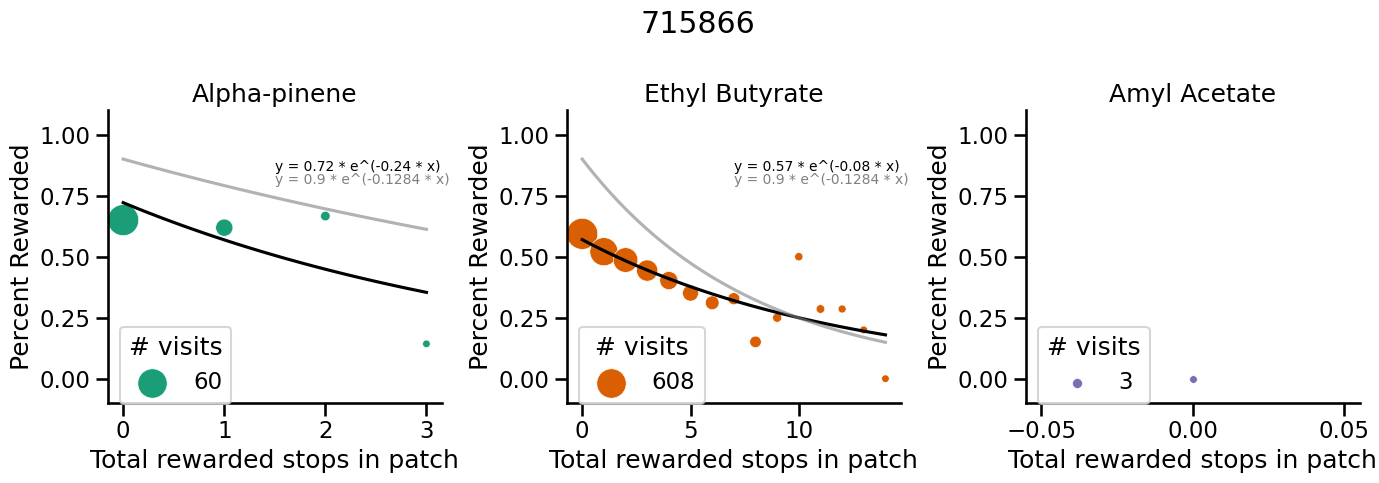

ValueError: `ydata` must not be empty!

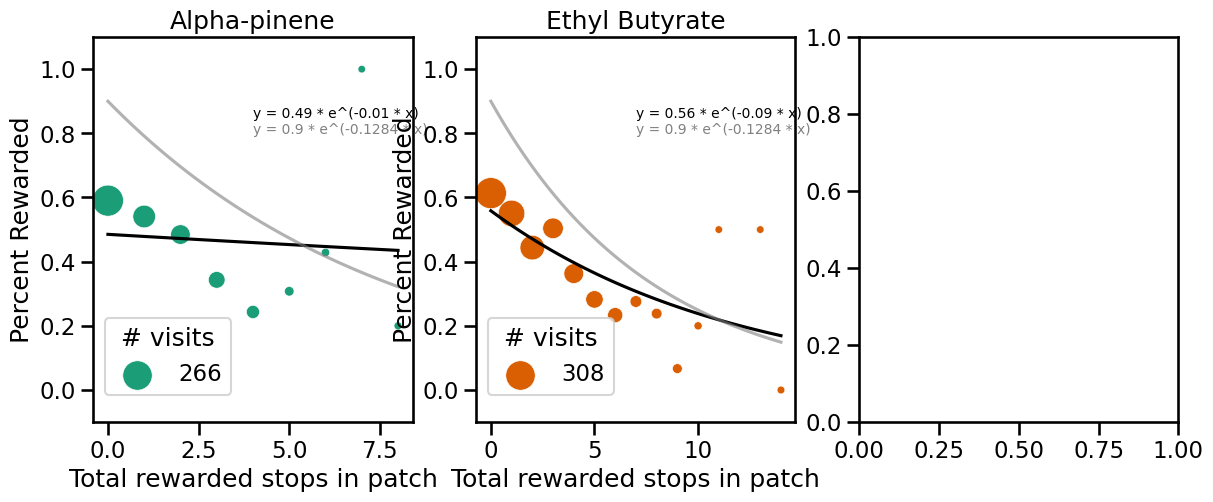

In [81]:
summary = experiment_df.loc[(experiment_df.has_choice == True)].groupby(['cumulative_rewards','mouse','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    fig, ax = plt.subplots(1,3,figsize=(14, 5))
    i = 0
    for odor in dict_odor.keys():

        odor_df = summary.loc[(summary['odor_label'] == odor)&(summary['mouse'] == mouse)]
        # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
        odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

        sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
        
        # Plot exponential curve
        popt, pcov = curve_fit(exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
        
        # Plot curve for this odor in theroy
        rate = dict_odor[odor]['rate']
        offset = dict_odor[odor]['offset']
        if popt[1] < 0:
            x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
            ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
            ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
            ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
            ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

        ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
        ax[i].set_ylim(-0.1,1.1)
        ax[i].set_title(odor)
        ax[i].set_xlabel('Total rewarded stops in patch')
        ax[i].set_ylabel('Percent Rewarded')

        i +=1
    sns.despine()
    plt.suptitle(mouse)
    plt.tight_layout()
    fig.savefig(results_path+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
    
    plt.show()

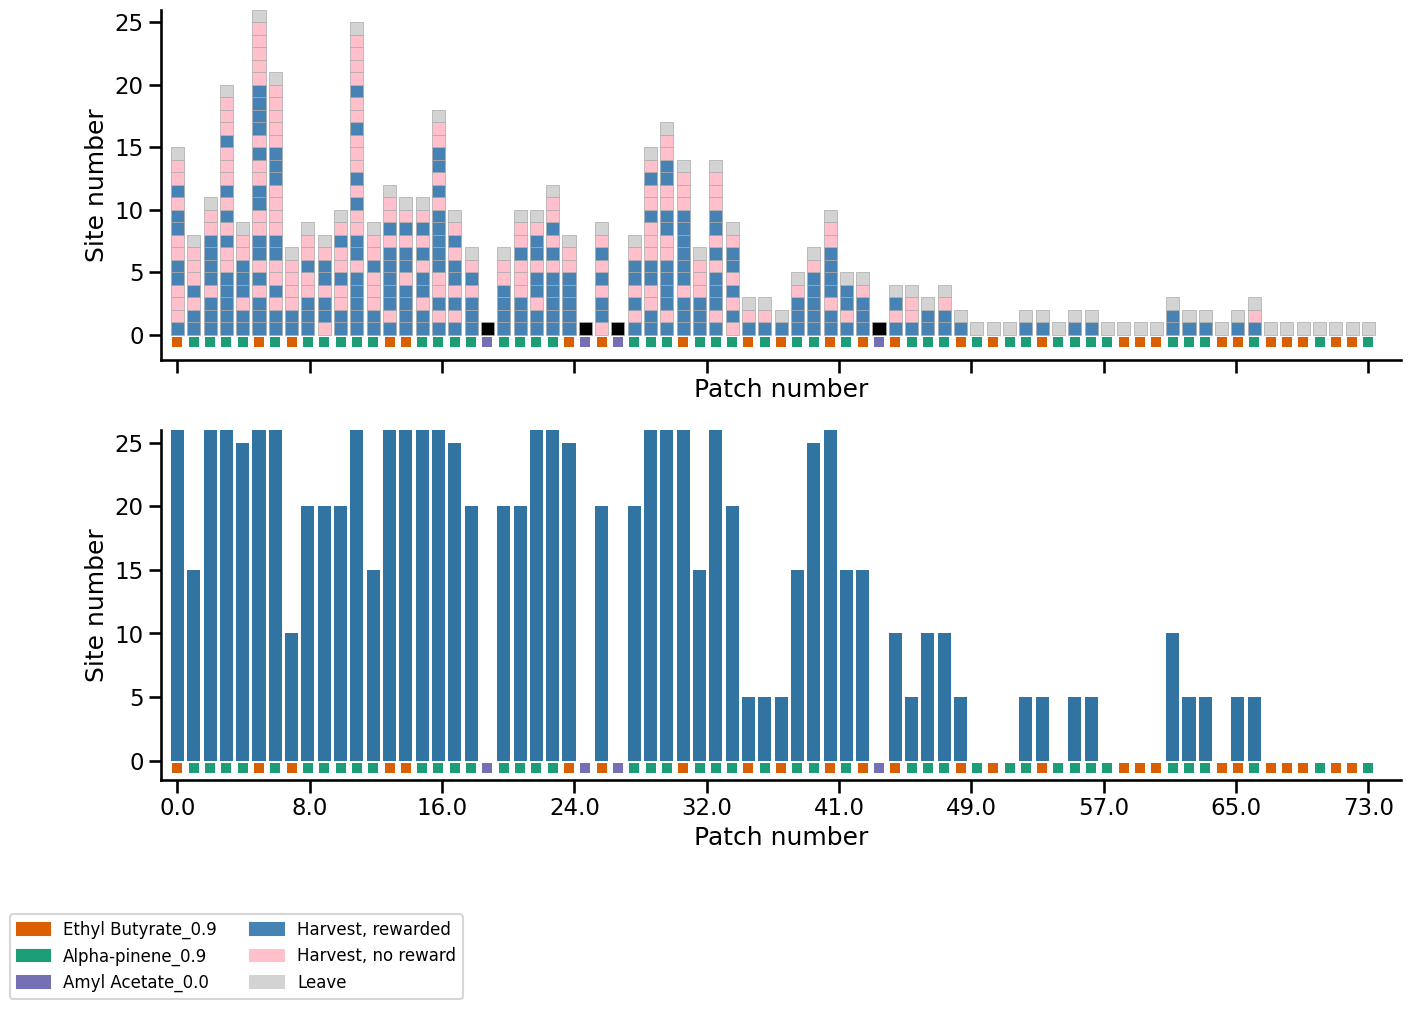

In [50]:
summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','visit_number':'count'})

patch_number = len(reward_sites.active_patch.unique())
number_odors = len(reward_sites['odor_label'].unique())
list_odors = []
for odor in reward_sites.odor_label.unique():
    list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
grid = (np.array(list_odors)/patch_number)*number_odors

fig, ax = plt.subplots(2,1, figsize=(16, 10), sharex=True)

for index, row in reward_sites.iterrows():
    if row['reward_delivered'] == 1 and row['has_choice'] == True:
        color='steelblue'
    elif row['reward_delivered'] == 0 and row['has_choice'] == True:
        color='pink'
        if row['reward_available'] == 0:
            color='crimson'
    else:
        if  row['reward_available'] == 0:
            color='black'
            hatch = '/'
        else:
            color='lightgrey'
        
    ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
    ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
    ax[0].set_xlim(-1,50)
    ax[0].set_xlabel('Patch number')
    ax[0].set_ylabel('Site number')
    
    if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
        patch_color=odor_list_color[0]
    elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
        patch_color=odor_list_color[1]
    else:
        patch_color=odor_list_color[2]
    
    # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
    ax[0].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)
    ax[1].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)

odors = []
for index, odor in enumerate(reward_sites['odor_label'].unique()):
    odors.append(mpatches.Patch(color=odor_list_color[index], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
label_4 = mpatches.Patch(color='lightgrey', label='Leave')

odors.extend([label_2, label_3,label_4])
plt.legend(handles=odors, loc='lower right', bbox_to_anchor=(0.25, -0.65), fontsize=12, ncol=2)
ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

summary = reward_sites.groupby(['active_patch','odor_label']).agg({'collected':'sum','has_choice':'sum'})
summary.reset_index(inplace=True)

sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None)
sns.barplot(x='active_patch', y='collected', data=summary, ax=ax[1], errorbar=None)

# ax2.set_xlim(-1,reward_sites.active_patch.nunique()+1)

# Specifying the number of xticks
num_ticks = 10  # Change this to the desired number of ticks
xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

# Specifying the xticks
ax[1].set_xticks(xticks)
ax[1].set_xlim(-1,75)
ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
ax[1].set_ylabel('Site number')
ax[1].set_xlabel('Patch number')
sns.despine()

fig.savefig(foraging_figures+f'/raster_plot_example_{mouse}_{date}.svg', dpi=300, bbox_inches='tight')

## When are animals deciding to leave each patch?

<Axes: xlabel='experiment', ylabel='reward_delivered'>

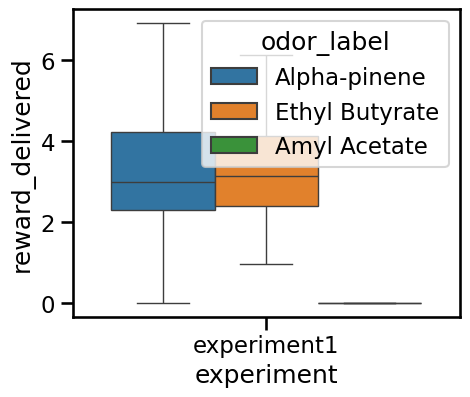

In [89]:
fig = plt.figure(figsize=(5,4))
# ax = plt.subplot(1,1,1)

summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.environment == 'low')].groupby(['session','mouse','active_patch','odor_label','experiment']).agg({'reward_delivered':'sum','visit_number':'count'})
summary = summary.loc[summary.visit_number > 1]
summary = summary.groupby(['session','mouse','odor_label','experiment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)

sns.boxplot(x='experiment', y='reward_delivered', hue='odor_label', data=summary)

In [ ]:
summary = experiment_df.loc[(experiment_df.visit_number != 0)].groupby(['session','mouse','active_patch','odor_label']).agg({'reward_delivered':'sum','visit_number':'count'})
summary = summary.loc[summary.visit_number > 1]
summary = summary.groupby(['session','mouse','odor_label']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 4, i + 1)
    sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], showfliers=False, ax =ax)
    sns.catplot(x='experiment', y='reward_delivered', hue='odor_label', kind='box', data=summary, height=6, aspect=1.5)
    
    strip = sns.stripplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], ax =ax, linewidth=0.2, edgecolor='black', jitter=0.25)
 
    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total reward \n collected')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-1,10)
    plt.xlabel('Initial P(reward)')

    sns.despine()
    
plt.suptitle('Reward collected per patch')
plt.tight_layout()

fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[summary.visit_number > 1]
summary = summary.groupby(['mouse','odor_label'])['reward_delivered'].mean().reset_index()

fig = plt.figure(figsize=(3.5,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)

plt.ylabel('Total rewards \n collected')
plt.xticks([0,1],[0.9,0.6])
plt.xlabel('Initial P(reward)')
plt.ylim(-1,7)

sns.despine()
    
plt.tight_layout()

fig.savefig(results_path+f'/prewardpecrease_total_reward_collected_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Alpha-pinene'))|((summary.odor_label == 'Ethyl Butyrate')&(summary.visit_number > 1))|(summary.odor_label == 'Amyl Acetate')]
summary = summary.groupby(['session','mouse','odor_label']).agg({'collected':'mean','visit_number':'mean'})
summary['visit_number']-=1
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 4, i + 1)
    sns.stripplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'], data=summary.loc[summary.mouse == mouse], ax =ax, jitter=0.25)
    # sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total stops')
    plt.xticks([0,1,2],[0.9,0.6,0])
    plt.ylim(-1, 20)
    plt.hlines(0, -0.3, 2.3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total harvests per odor per mouse', fontsize=20)
plt.tight_layout()

fig.savefig(results_path+f'/prewardDecrease_total_visits_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary['visit_number']-=1

summary = summary.groupby(['mouse','odor_label'])['visit_number'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene', 'Amyl Acetate'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene', 'Amyl Acetate'], data=summary)

plt.ylabel('Total stops')
plt.xticks([0,1,2],[0.9,0.6,0])
plt.xlabel('Initial P(reward)')
plt.ylim(-1,15)
plt.hlines(0, -0.3, 2.3, color='black', linestyle='--', linewidth=1)

sns.despine()
    
plt.tight_layout()

fig.savefig(results_path+f'/PrewardDecrease_total_visits_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[~((summary_df.visit_number == 0)&(summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()

summary = summary.groupby(['session','mouse','odor_label']).agg({'collected':'mean','reward_probability':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    plt.subplot(3, 4, i + 1)
    sns.stripplot(x='odor_label', y='reward_probability', hue='odor_label', palette = ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], jitter=0.25)
    sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene',],  data=summary.loc[summary.mouse == mouse], showcaps=False, showfliers=False)

    # sns.violinplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], cut=True)
    plt.title(mouse)
    if experiment == 'experiment1':
        plt.hlines(max(summary_df.loc[summary_df.mouse == mouse].reward_probability), -0.5, 0.5, color=color1, linestyle='--', alpha=0.5)
        plt.hlines(max(summary_df.loc[summary_df.mouse == mouse].reward_probability), 0.5, 1.5, color=color2, linestyle='--', alpha=0.5)
    
    else:
        plt.hlines(0.9, -0.5, 0.5, color=color1, linestyle='--', alpha=0.5)
        plt.hlines(0.6, 0.5, 1.5, color=color2, linestyle='--', alpha=0.5)

    plt.xlabel('')
    plt.ylabel('P(reward) when \n leaving a patch')
    plt.xlabel('Initial P(reward)')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(0.25,0.91)
    sns.despine()
    
plt.tight_layout()

fig.savefig(results_path+f'/PrewardDecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
from scipy import stats
summary = summary.groupby(['mouse','odor_label'])['reward_probability'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.violinplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, cut=True)
sns.stripplot(x='odor_label', y='reward_probability', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], jitter=0.3, data=summary)

plt.hlines(0.9, -0.5, 0.5, color=color1, linestyle='--', alpha=0.5)
plt.hlines(0.6, 0.5, 1.5, color=color2, linestyle='--', alpha=0.5)
# plt.hlines(0.0, 1.5, 2.5, color=color3, linestyle='--', alpha=0.5)
results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Ethyl Butyrate'].groupby('mouse')['reward_probability'].mean(), summary.loc[summary['odor_label'] == 'Alpha-pinene'].groupby('mouse')['reward_probability'].mean())
print(results)

plt.ylabel('P(reward) when \n leaving a patch')
plt.xlabel('Initial P(reward)')

plt.xticks([0,1],[0.9,0.6])
plt.ylim(0.25,0.91)

sns.despine()
    
plt.tight_layout()

fig.savefig(results_path+f'/PrewardDecrease_preward_when_leave_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
sns.displot(summary, x='reward_probability', hue='odor_label', kind='kde', palette=color_dict_label, fill=True)

In [ ]:
summary = summary_df.loc[~((summary_df.visit_number == 0)&(summary_df.has_choice == False)&(summary_df.odor_label == 'Ethyl Butyrate'))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'})
summary.reset_index(inplace=True)
summary = summary.loc[summary.odor_label != 'Amyl Acetate']
summary = summary.loc[(summary.odor_label == 'Ethyl Butyrate')|((summary.odor_label == 'Alpha-pinene')&(summary.reward_probability <= 0.6))]

fig, ax = plt.subplots(3,4,figsize=(16,12))
i=0
j=0
for k, mouse in enumerate(summary.mouse.unique()):
    sns.kdeplot(summary.loc[summary.mouse == mouse], x='reward_probability', hue='odor_label', palette=color_dict_label, ax = ax[i][j], legend=False)
    for odor_label in summary.odor_label.unique():
        ax[i][j].vlines(x=summary.loc[(summary.mouse == mouse)&(summary.odor_label == odor_label)].reward_probability.median(), ymin=0, ymax=2, color=color_dict_label[odor_label], linestyle='--')
    ax[i][j].set_title(mouse)
    ax[i][j].set_xlabel('Odor')
    ax[i][j].set_ylabel('Density')
    ax[i][j].set_xlabel('P(reward) uppon \nleaving patch')
    j += 1
    if j == 4:
        i += 1
        j = 0
        
    plt.suptitle('Total visits per odor per mouse', fontsize=20)
    plt.tight_layout()
    sns.despine()

fig.savefig(results_path+f'/PrewardDecrease_preward_when_leaving_density_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary.loc[summary.mouse != '715866']

In [ ]:
# # Initialize an empty DataFrame
df_concatenated = pd.DataFrame(columns=['x', 'y', 'mouse', 'odor'])
for odor_label in summary.odor_label.unique():
    # Generate KDE for each distribution
    for mouse in summary.mouse.unique():
        kde_df = pd.DataFrame()
        dist = summary.loc[(summary.mouse == mouse)&(summary.odor_label == odor_label)]['reward_probability']
        
        # Generate KDE for the current distribution
        sns.kdeplot(dist, color='grey', alpha=0.3).get_lines()[0].get_data()
        
        # Get the current axes
        ax = plt.gca()

        # Extract x and y data for the first KDE
        kde1_line = ax.lines[0]
        x_kde = kde1_line.get_xdata()
        y_kde = kde1_line.get_ydata()
        
        # Create DataFrame for the current distribution
        df = pd.DataFrame({'x': x_kde, 'y': y_kde, 'mouse': mouse, 'odor': odor_label})
        
        # Append DataFrame to the concatenated DataFrame
        df_concatenated = pd.concat([df_concatenated, df], ignore_index=True)  
        plt.close()


In [ ]:
df_concatenated['x'] = df_concatenated['x'].round(2)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.lineplot(x='x', y='y', hue='mouse', data=df_concatenated.loc[df_concatenated.odor == 'Alpha-pinene'], palette='Greens', legend=False, ax=ax[0])
sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Alpha-pinene'], color=color2, legend=False, ax=ax[1], errorbar=('ci', 95))
ax[0].set_xlabel('P(reward) when leaving')
ax[1].set_xlabel('P(reward) when leaving')
ax[0].set_ylabel('Density')
ax[0].set_title('Individual animals')
ax[1].set_title('Average')

sns.despine()
plt.suptitle('Initial P(reward) of 0.6')
plt.tight_layout()

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.lineplot(x='x', y='y', hue='mouse', data=df_concatenated.loc[df_concatenated.odor == 'Ethyl Butyrate'], palette='Oranges', legend=False, ax=ax[0])
sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Ethyl Butyrate'], color=color1, legend=False, ax=ax[1])
ax[0].set_xlabel('P(reward) when leaving')
ax[1].set_xlabel('P(reward) when leaving')
ax[0].set_title('Individual animals')
ax[1].set_title('Average')
ax[0].set_ylabel('Density')
sns.despine()
plt.suptitle('Initial P(reward) of 0.9')
plt.tight_layout()

In [ ]:
fig= plt.subplots(1,1, figsize=(6,5))

sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Ethyl Butyrate'],color=color1, label = 'P(Reward) = 0.9', legend=False)
sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Alpha-pinene'], color=color2, label = 'P(Reward) = 0.6', legend=False)
plt.xlabel('P(reward) when leaving')
plt.ylabel('Density')
plt.legend()
sns.despine()
plt.tight_layout()


In [ ]:
count = 0
initial_time_patch = 0
summary_df['cumulative_reward'] = 0
summary_df['time_elapsed_patch'] = 0
summary_df['position_elapsed_patch'] = 0

for i, row in summary_df.iterrows():
    if row['visit_number'] == 0:
        initial_time_patch = i
        initial_position_patch = row['start_position']
        count = 0
    count += row['reward_delivered']
    summary_df.at[i, 'cumulative_reward'] = count 
    
    summary_df.at[i, 'position_elapsed_patch'] = round_to_pair(row['start_position'] - initial_position_patch, 2)
    
    if row['stop_time'] is not None:
        summary_df.at[i, 'time_elapsed_patch'] = round_to_pair(row['stop_time'] - initial_time_patch, 2)
    else:
        try:
            summary_df.at[i, 'time_elapsed_patch'] = round_to_pair(row['odor_offset'] - initial_time_patch, 2)
        except:
            summary_df.at[i, 'time_elapsed_patch'] = round_to_pair(i - initial_time_patch, 2)

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'time_elapsed_patch':'max'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 4, i + 1)
    sns.stripplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'], data=summary.loc[summary.mouse == mouse], ax =ax, linewidth=0.2, edgecolor='black', jitter=0.25)
    test = sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    # sns.boxplot(x='odor_label', y='time_elapsed_patch', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)
    ylims=test.get_ylim()
    ax.set(ylim=ylims)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Time in patch (s)')
    plt.xticks([0,1,2],[0.9,0.6,0])
    # plt.ylim(-1, 25)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total visits per odor per mouse', fontsize=20)
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_time_elapsed_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
no_reward = 0
for index, row in summary_df.iterrows():
    if row['visit_number'] == 0:
        no_reward = 0
        
    if row['reward_delivered'] == 0 and row['has_choice'] == True:
        no_reward +=1

    summary_df.loc[index, 'past_no_reward'] = no_reward

In [ ]:
summary = summary_df.loc[summary_df.visit_number !=0].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'cumulative_failures':'max'})
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','cumulative_failures':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(16,10))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 5, i + 1)
    sns.stripplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[(summary.mouse == mouse)&(summary.experiment=='base')], ax =ax, jitter=-0.25)
    sns.stripplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette =  ['red','red','red'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[(summary.mouse == mouse)&(summary.experiment=='experiment1')], ax =ax, jitter=0.25)
    
    # sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    sns.boxplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total no rewards\n when leaving')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-1, 13)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total visits per odor per mouse', fontsize=20)
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_total_failures_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary.groupby(['mouse','odor_label'])['past_no_reward'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='past_no_reward', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='past_no_reward', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)
sns.lineplot(x='odor_label', y='past_no_reward', hue='odor_label', data=summary, legend=False)

plt.ylabel('Total no rewards \n in patch')
plt.xticks([0,1],[0.9,0.6])
plt.xlabel('Initial P(reward)')
plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')

results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Ethyl Butyrate'].groupby('mouse')['past_no_reward'].mean(), summary.loc[summary['odor_label'] == 'Alpha-pinene'].groupby('mouse')['past_no_reward'].mean())
print(results)

sns.despine()
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_past_no_reward_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
failure_consecutive = 0
for index, row in summary_df.iterrows():
    if row['active_patch'] != previous_patch:
        previous_patch = row['active_patch']
        failure_consecutive = 0
    else:
        if row['reward_delivered'] == 0 and row['has_choice'] == True:
            failure_consecutive += 1
        else:
            failure_consecutive = 0
        
    summary_df.loc[index, 'consecutive_failure'] = failure_consecutive

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','success_number':'max','consecutive_failure':'max'})
summary = summary.groupby(['session','mouse','odor_label']).agg({'consecutive_failure':'mean'}).reset_index()
summary.reset_index(inplace=True)
summary.head(20)

plt.figure(figsize=(12,10))
for i, mouse in enumerate(summary.mouse.unique()):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='odor_label', y='consecutive_failure',hue='odor_label', palette=color_dict_label, order=  ['Ethyl Butyrate',  'Alpha-pinene'],data=summary.loc[(summary.mouse == mouse)], showfliers=False)
    sns.stripplot(x='odor_label', y='consecutive_failure', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse],  jitter=0.25)
    plt.title(mouse)
    plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')
    plt.xlabel('')
    plt.ylabel('Consecutive failures \n before leaving') 
    plt.xticks([0,1],[0.9,0.6])
    # plt.ylim(-3,2.5)
    sns.despine()
    
plt.tight_layout()
fig.savefig(foraging_figures+f'/PrewardDecrease_consecutive_failure_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[summary_df.last_visit == 1].groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','consecutive_failure':'max'})
summary.reset_index(inplace=True)
summary = summary.groupby(['mouse','odor_label'])['consecutive_failure'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='consecutive_failure', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='consecutive_failure', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)

results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Ethyl Butyrate'].groupby('mouse')['consecutive_failure'].mean(), summary.loc[summary['odor_label'] == 'Alpha-pinene'].groupby('mouse')['consecutive_failure'].mean())
print(results)

plt.ylabel('Consecutive no rewards \n in patch')
plt.xticks([0,1,2],[0.9,0.6,0])
plt.xlabel('Initial P(reward)')
plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_consecutive_failure_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','success_number':'max','past_no_reward':'max'})
summary.reset_index(inplace=True)
summary['ratio'] = summary['success_number'] - summary['past_no_reward']
summary = summary.groupby(['session','mouse','odor_label']).agg({'ratio':'mean'}).reset_index()
summary.reset_index(inplace=True)
summary.head(20)

plt.figure(figsize=(12,10))
for i, mouse in enumerate(summary.mouse.unique()):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='odor_label', y='ratio',hue='odor_label', palette=color_dict_label, order=  ['Ethyl Butyrate',  'Alpha-pinene'],data=summary.loc[(summary.mouse == mouse)], showfliers=False)
    sns.stripplot(x='odor_label', y='ratio', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse],  jitter=0.25)
    plt.title(mouse)
    plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')
    plt.xlabel('')
    plt.ylabel('Rewards - failures')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-3,2.5)
    sns.despine()
    
plt.tight_layout()
fig.savefig(foraging_figures+f'/PrewardDecrease_ratio_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','success_number':'max','past_no_reward':'max'})
summary.reset_index(inplace=True)
summary['ratio'] = summary['success_number'] - summary['past_no_reward']
summary = summary.groupby(['mouse','odor_label'])['ratio'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='ratio', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='ratio', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)

plt.ylabel('Rewards - failures')
plt.xticks([0,1,2],[0.9,0.6,0])
plt.xlabel('Initial P(reward)')
plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_ratio_average.svg', dpi=300, bbox_inches='tight')

### How fast do animals move in the interpatch?


In [ ]:
trial_summary = plotting.trial_collection(active_site.loc[active_site.label == 'InterPatch'], encoder_data, mouse, session, window=(-0.5,2))

In [ ]:
plt.figure(figsize=(16,12))
for i, mouse in enumerate(summary.mouse.unique()):
    plt.subplot(3, 4, i + 1)
    sns.regplot(x='past_no_reward_count', y='collected', data=summary.loc[(summary.mouse == mouse)&(summary.odor_label == 'Ethyl Butyrate')], scatter_kws={'s':10})

    plt.title(mouse)
    sns.despine()
    
plt.tight_layout()

# Experiment 1

Change one patch to match the offset of the other one. Some animals with two patches with 0.6 initial p(reward) and some animals with 0.9

In [ ]:
if summary_df.empty:
    print('Loading')
    summary_df = pd.read_csv(os.path.join(foraging_figures, 'reward_probability_joined.csv'))
else:
    print('Saving')
    summary_df.to_csv(os.path.join(foraging_figures, 'reward_probability_joined.csv'))

In [ ]:
summary_df

In [ ]:
summary = summary_df.loc[~((summary_df.visit_number == 0)&(summary_df.has_choice == False))].groupby(['session_n','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.groupby(['session_n','mouse','odor_label']).agg({'collected':'mean','reward_probability':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(18,18))
for i, mouse in enumerate(summary.mouse.unique()):
    # print(summary.loc[summary.mouse == mouse])
    plt.subplot(5, 2, i + 1)
    sns.lineplot(x='session_n', y='reward_probability', hue='odor_label', data=summary.loc[summary.mouse == mouse], legend=False, marker='o')    
    # sns.violinplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], cut=True)
    plt.title(mouse)
    sns.despine()
    
plt.tight_layout()